This notebook requires a pair of untransformed and annotation-based transformed embeddings. The snakemake worflow in this repository contains rules for generating these embedding pairs with UMAP for FAUST annotations (`{name}_embedding_output.parquet` ). An example pair can be generated via,

```bash
snakemake --cores all \
    data/mair-2022-ismb/TISSUE_138_samples_FM96_OM138_035_CD45_live_fcs_110595_umap.parquet \
    data/mair-2022-ismb/TISSUE_138_samples_FM96_OM138_035_CD45_live_fcs_110595_umap_annotated.parquet
```

which downloads [sample annotations](https://figshare.com/articles/dataset/ISMB_BioVis_2022_Data/20301639) from figshare and executes the embedding rules automatically.


In [1]:
import pathlib

import pandas as pd
import numpy as np
import jscatter

data_dir = pathlib.Path.cwd() / ".." / "data" / "mair-2022-ismb"
name = "TISSUE_138_samples_FM96_OM138_035_CD45_live_fcs_110595"

raw = pd.read_parquet(data_dir / f"{name}_umap_annotated.parquet")
annotated = pd.read_parquet(data_dir / f"{name}_umap.parquet")

# point–point comparison (*k* 1–10)

- Jaccard distance: $\frac{ | A \cap B | }{ | A \cup B | } = \frac{ | A \cap B | }{ | A | + | B | - | A \cap B | }$


In [2]:
from typing import Union

from sklearn.neighbors import NearestNeighbors
from numba import njit
import numpy.typing as npt

@njit
def _jaccard(A: npt.ArrayLike, B: npt.ArrayLike) -> npt.NDArray:
    dist = np.zeros(len(A))
    for i, rows in enumerate(zip(A, B)):
        a = set(rows[0])
        b = set(rows[1])
        intersect = a.intersection(b)
        dist[i] = len(intersect) / (len(a) + len(b) - len(intersect))
    return dist

def jaccard_pointwise(X0: npt.ArrayLike, X1:  npt.ArrayLike, n_neighbors: int) -> npt.NDArray:
    indices = []
    for X in (X0, X1):
        # first neighbor is always self, so increment provided k by one
        nbrs = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(X)
        ind = nbrs.kneighbors(X, return_distance=False)
        indices.append(ind[:, 1:])
        
    return _jaccard(*indices)

In [3]:
# comparret the distribution of 
distances = {
    k: jaccard_pointwise(annotated[["x", "y"]], raw[["x", "y"]], n_neighbors=k)
    for k in (3, 5, 10, 20, 30, 40, 60, 99)
}

<AxesSubplot: ylabel='Proportion'>

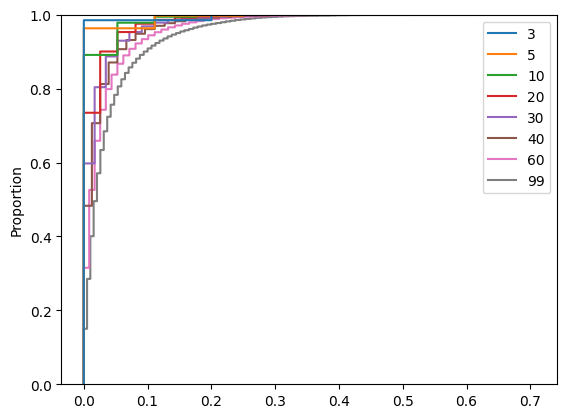

In [4]:
import seaborn as sns

sns.ecdfplot(distances)

# label–point comparison

- "group-wise" Jaccard distance: $\frac{\bigcup_{i \in I} A_i \cap B_i}{\bigcup_{i \in I} A_i \cup B_i}$, where $I$ is a set of points with a given label

- Alternatively, view the distribution/summary of Jaccard distances for all points in a group

TODO

# label–label comparision

TODO